In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
import warnings


# Arguments

In [2]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,

        'learning rate':0.01,
        'training epochs':5000,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [3]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [4]:
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:]
temp = df.iloc[:,:11]


In [5]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [6]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [7]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)

spec_noisy = spec + noise

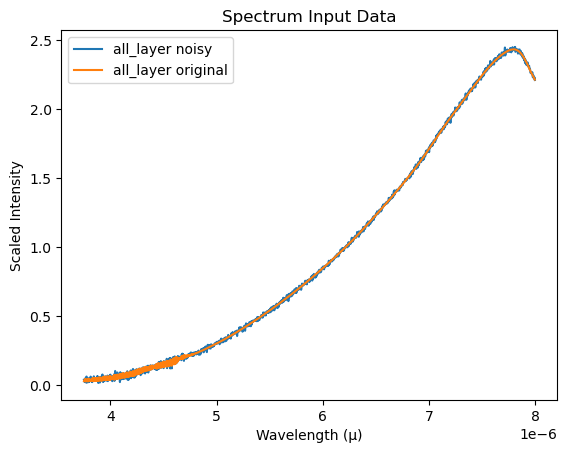

In [8]:
plt.title('Spectrum Input Data')
plt.plot(spec_noisy.iloc[0], label='all_layer noisy')
plt.plot(spec.iloc[0], label='all_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [9]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [10]:
temp

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,318.002181
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,301.044787
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,357.969610
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,328.143455
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,335.245173
...,...,...,...,...,...,...,...,...,...,...,...
2195,327.359960,331.887028,335.439802,327.858751,329.905634,332.466652,323.482462,319.992829,334.062241,326.323524,359.801763
2196,354.311013,341.927755,337.451821,323.967416,330.097748,313.792185,317.839648,318.627400,331.026918,344.846164,348.886578
2197,345.013997,323.826484,315.340107,306.337376,314.184375,306.270021,304.561202,313.513715,321.161351,326.559357,338.238519
2198,309.706144,313.843492,332.026895,338.820759,345.317550,352.584174,339.603698,337.521742,337.254720,328.544064,342.340353


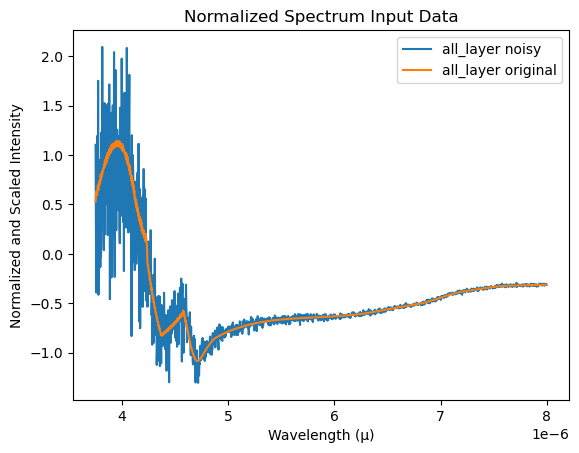

In [11]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_noisy_scaled_df.iloc[0], label='all_layer noisy')
plt.plot(spec_scaled_df.iloc[0], label='all_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [12]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

# Model Design

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin_fin = nn.Linear(30, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [14]:
# define model
_, all_layer_output_size = temp.shape
_, all_layer_input_size = spec_noisy_scaled_df.shape
model = Net(all_layer_input_size, all_layer_output_size)

# one_layer models are defined in training funciton

# Training Loops

In [15]:
#  training function
def train_model(model, spec_train):
    print('\nTRAINING MODEL')


    loss_list = []
    loss_sum = 0

    num_epochs = args['training epochs']
    criterion = args['loss fn']
    optimizer = args['optimizer'](model.parameters(), lr=args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = model(spec_train)

        # calculate loss
        loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'epoch: {epoch + 1}, loss = {loss}')

    print(f'epoch: {epoch + 1}, loss = {loss}')

    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\naverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list

In [16]:
training_losses = train_model(model, spec_train)


TRAINING ALL_LAYER MODEL
epoch: 500, loss = 3.990708827972412
epoch: 1000, loss = 3.5203330516815186
epoch: 1500, loss = 3.4502410888671875
epoch: 2000, loss = 3.431415557861328
epoch: 2500, loss = 3.4263060092926025
epoch: 3000, loss = 3.422677993774414
epoch: 3500, loss = 3.419487237930298
epoch: 4000, loss = 3.4165375232696533
epoch: 4500, loss = 3.413642168045044
epoch: 5000, loss = 3.410712718963623
epoch: 5000, loss = 3.410712718963623

average training loss (across all layers): 3.5647687263878023


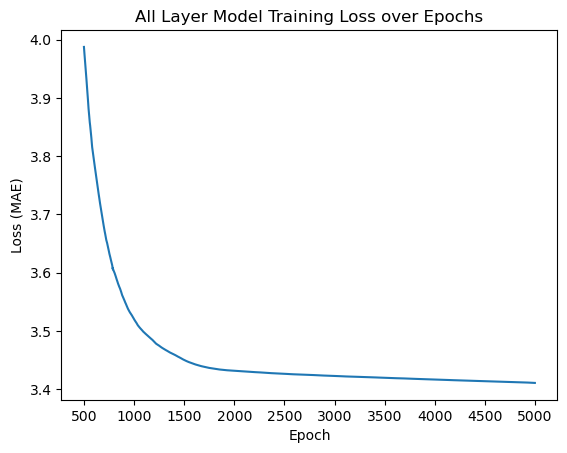

In [17]:
# plot training loss over epochs (after first 500 epochs)

# add 500 to x-axis values
x_values = range(500, args['training epochs'])
plt.plot(x_values, training_losses[500:])
plt.xticks(range(500, args['training epochs'] + 500, args['training epochs'] // 10))

plt.title("All Layer Model Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

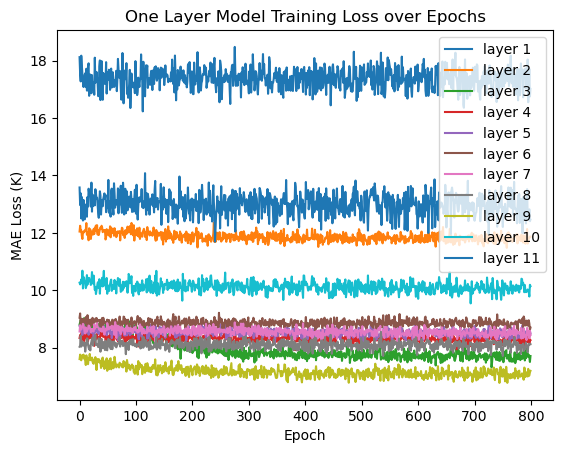

In [ ]:
for layer in layers:
    plt.plot(layer['train losses'][200:], label=layer['col'])

    
plt.title(f"One Layer Model Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

# Testing

In [18]:
# test data
pred_temp = model(spec_test)

In [19]:
# unscale spectrum data
spec_test = scaler.inverse_transform(spec_test)

In [20]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [4.637056061715791, 7.595430501302084, 4.082866645581794, 3.9841920332475143, 5.047389128713897, 4.728078345096472, 4.946636824174361, 3.9064970074277934, 3.9316728071732956, 2.743198602849787, 1.3560563058564157]


average test loss: 4.269006751194473


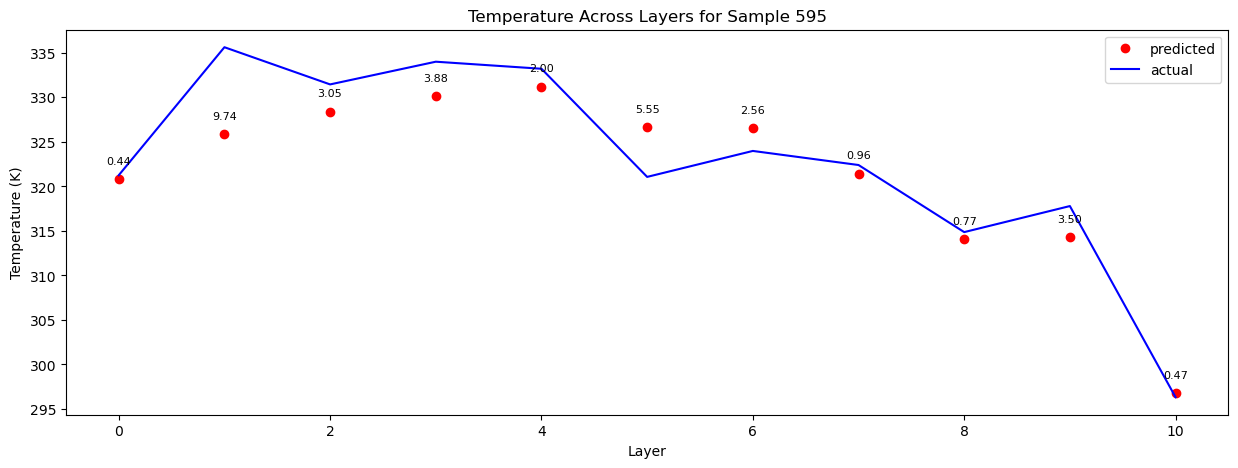

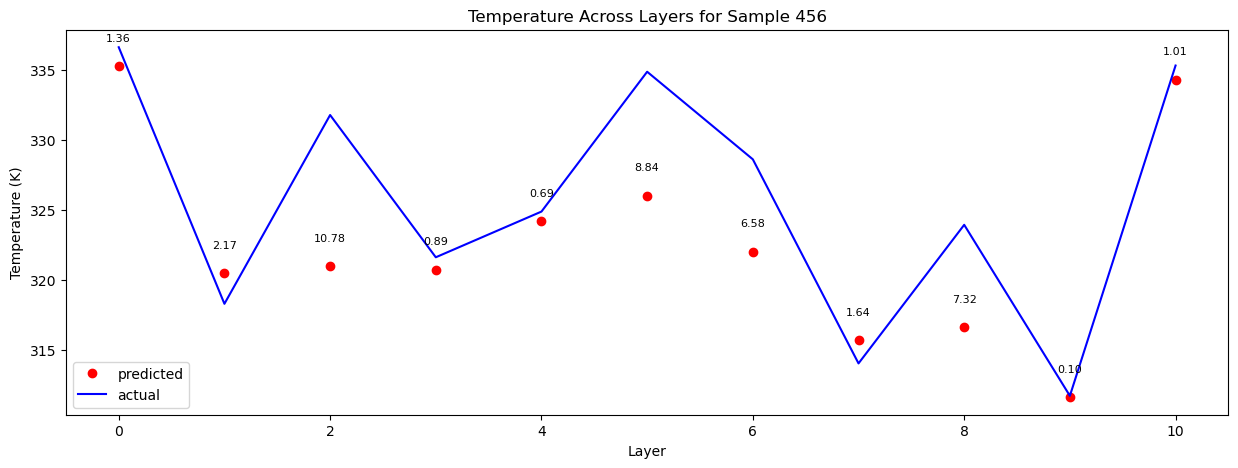

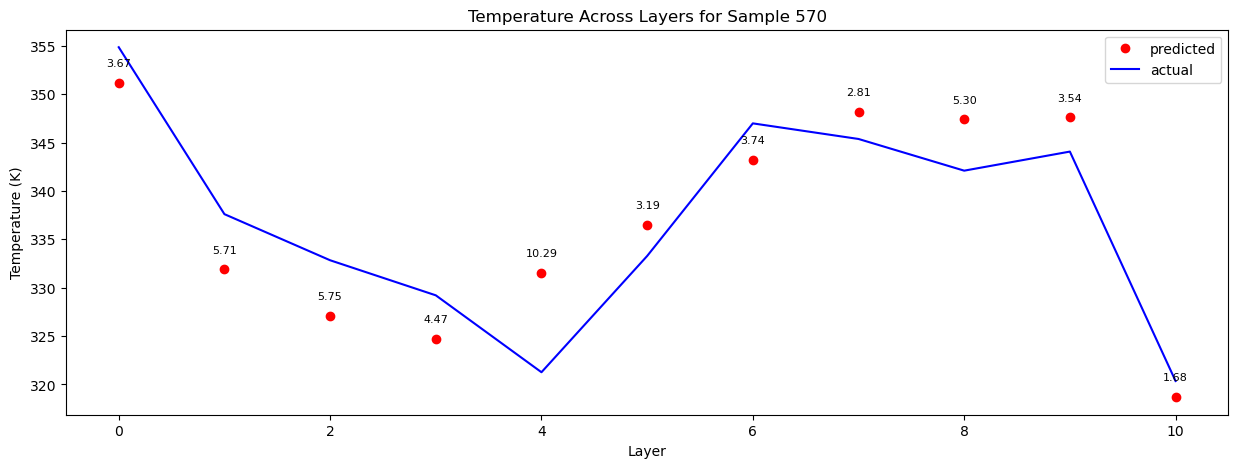

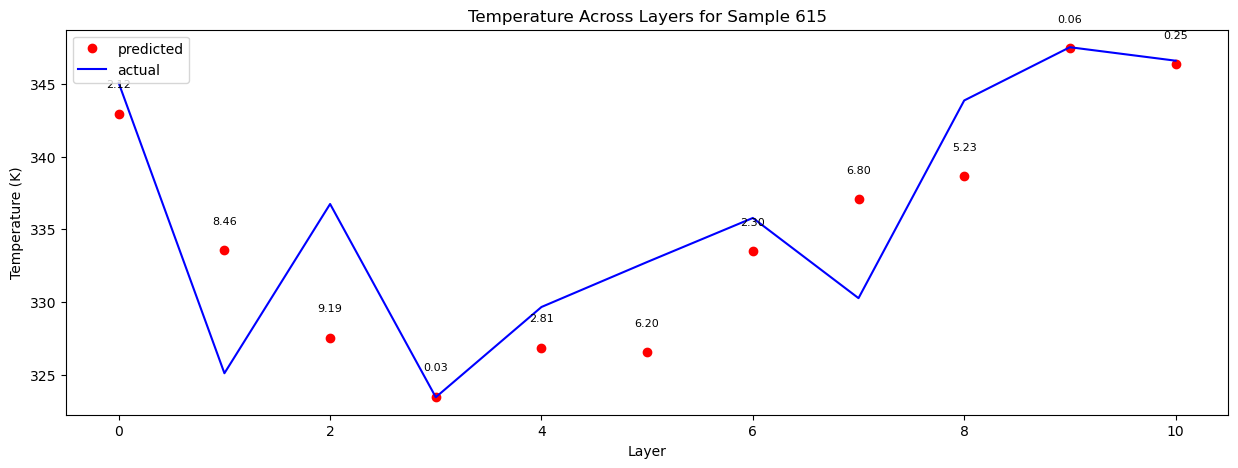

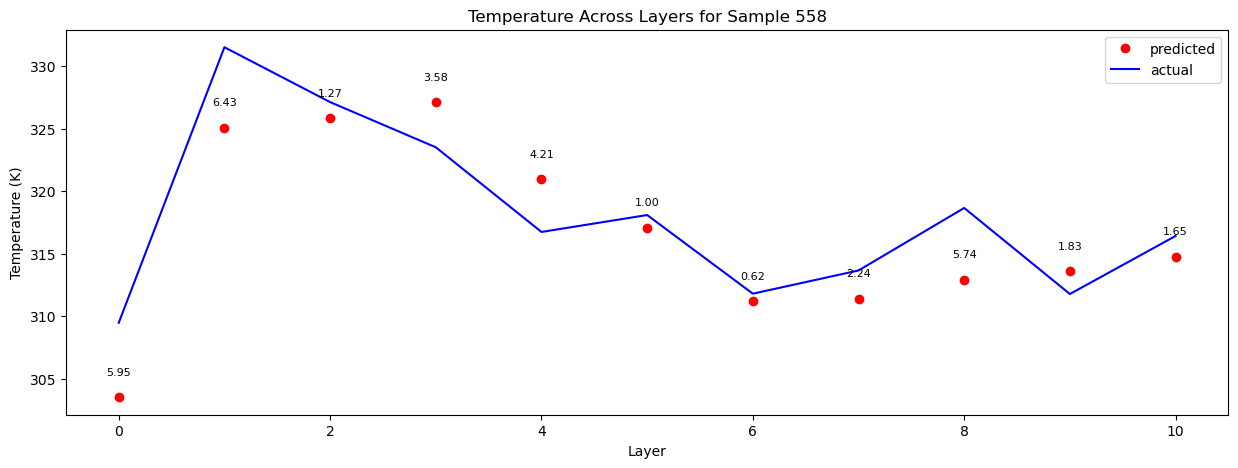

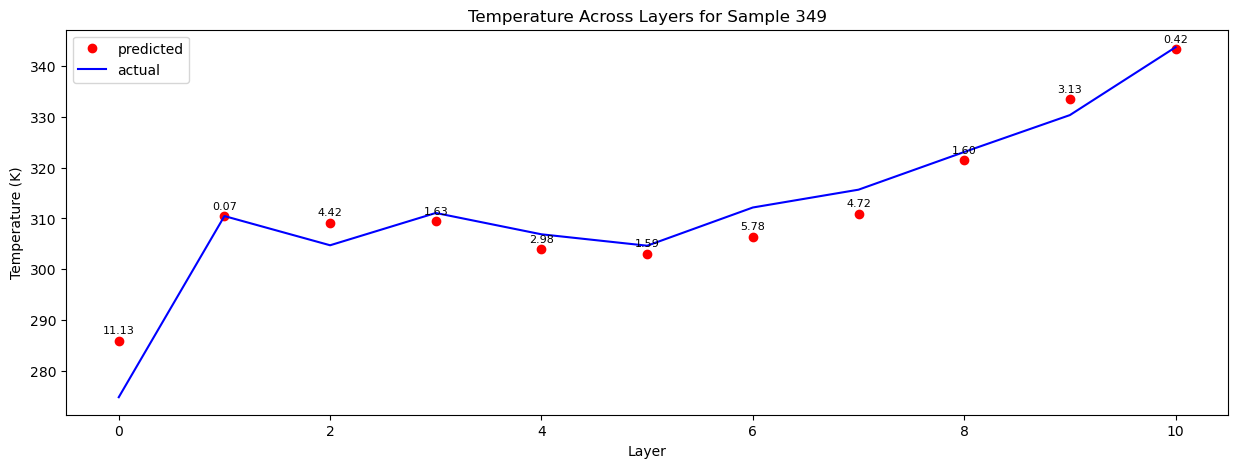

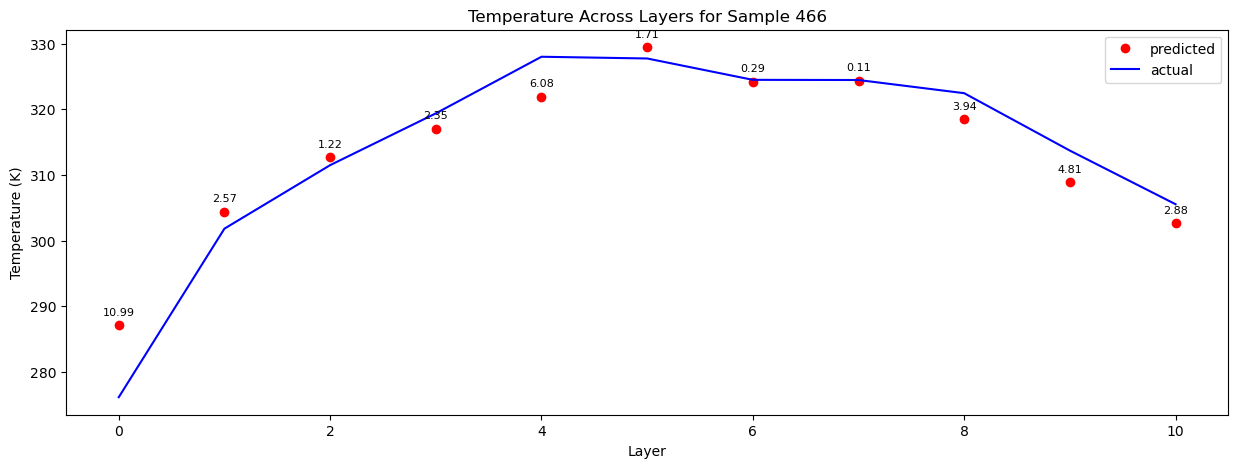

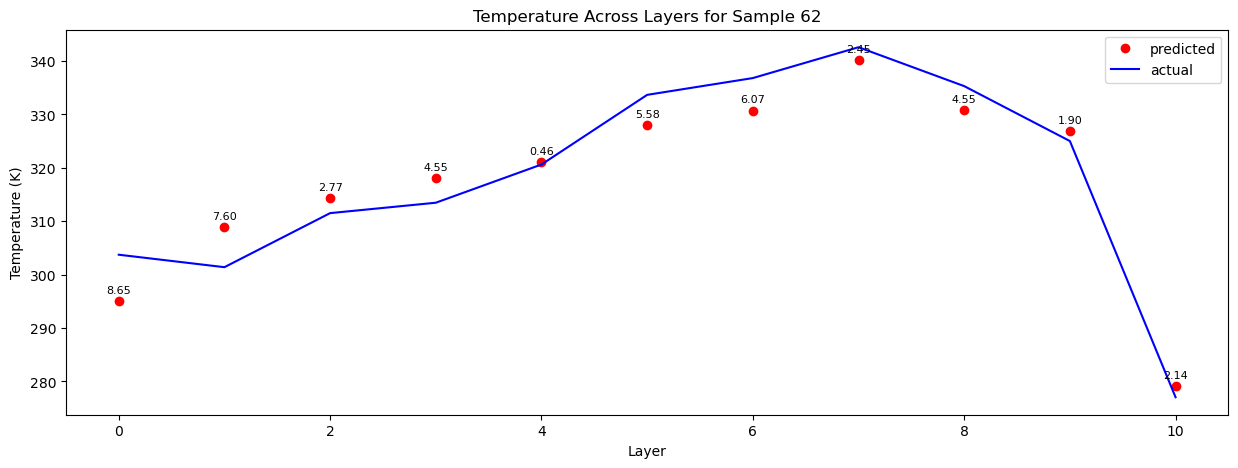

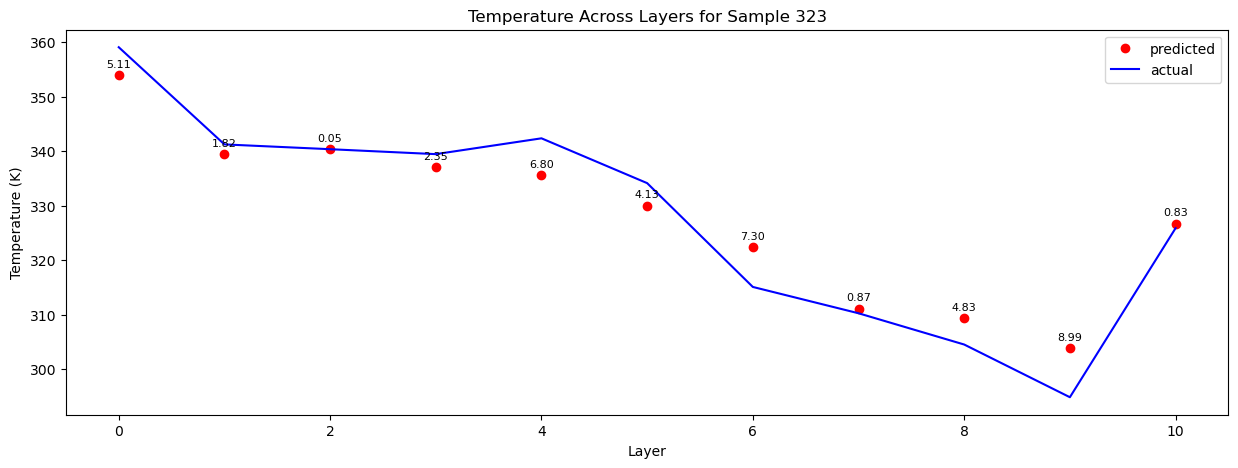

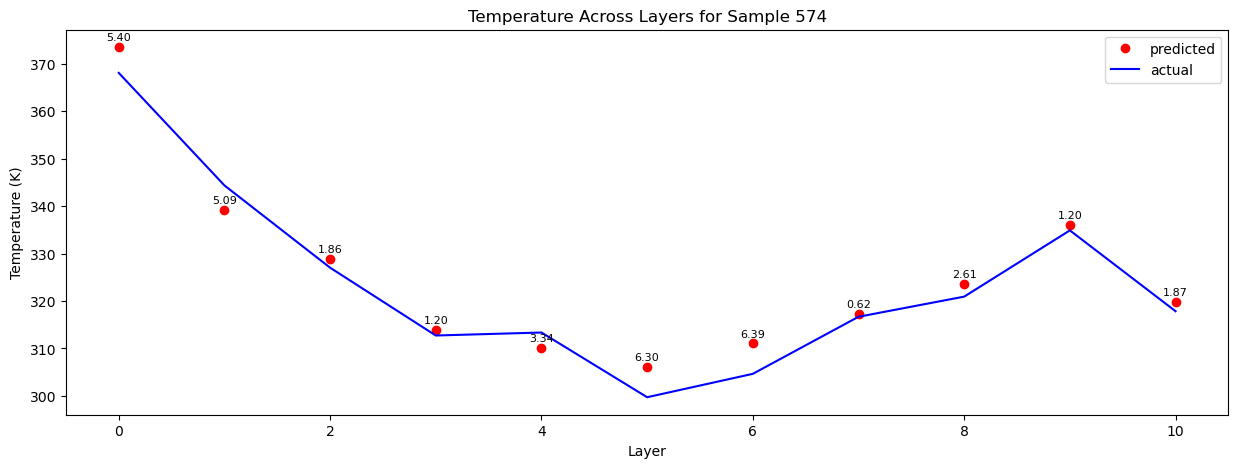

In [21]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')
    print(f'average test loss: {sum(test_losses)/len(test_losses)}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


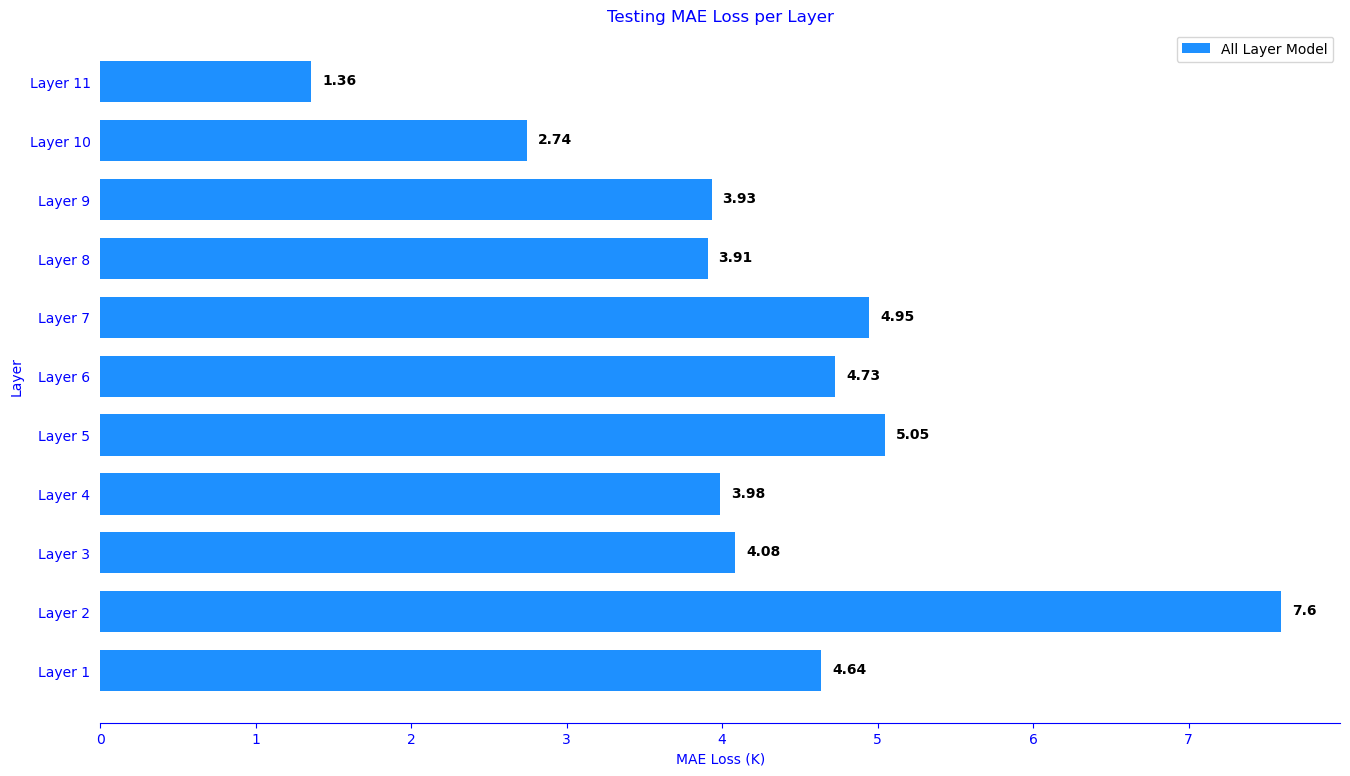

In [28]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')
    

# plot the bars
fig, ax = plt.subplots(figsize =(16, 9))
all_layer_bar = ax.barh(layer_names, test_losses, height=0.7, color='dodgerblue', label='All Layer Model')
 
# Remove axes splines
for s in ['top','right', 'left']:
    ax.spines[s].set_visible(False)
 
# Remove y Ticks
ax.yaxis.set_ticks_position('none')

# Add annotation to bars
for i, bar in enumerate(all_layer_bar):
    plt.text(bar.get_width()+0.07, bar.get_y()+0.3,
             str(round((bar.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='black')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)", fontweight='bold')
plt.ylabel("Layer", fontweight='bold')
plt.legend()

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()